In [1]:
%matplotlib inline

In [2]:
from sparapy.radiosity_fast import DRadiosityFast
from sparapy.radiosity import Radiosity
import sparapy.geometry as geo
import sparapy as sp
import cProfile
from datetime import datetime
import numpy as np


sample_walls = sp.testing.shoebox_room_stub(1, 1, 1)

In [3]:
def init_energy(rad, source_pos):
    source = geo.SoundSource(source_pos, [1, 0, 0], [0, 0, 1])
    E_matrix = []
    for patches in rad.patch_list:
        patches.init_energy_exchange(
            rad.max_order_k, rad.ir_length_s, source,
            sampling_rate=rad.sampling_rate)
        E_matrix.append(patches.E_matrix)
    return E_matrix

def calc_form_factor(rad):
    if len(rad.patch_list) > 1:
        for patches in rad.patch_list:
            patches.calculate_form_factor(rad.patch_list)


In [4]:
n_max = 5
repeat = 2
steps = 3 # create patches, init energy, form factor
steps_names = ['create patches', 'init energy', 'form factor']
fast_second = np.zeros((steps, n_max, repeat))
slow = np.zeros((steps, n_max, repeat))
number_of_patches = np.zeros((n_max))

# run one time, to get complied.
radiosity = DRadiosityFast.from_polygon(sample_walls, 1)
(energy, distance) = radiosity.init_energy([0.5, 0.5, 0.5])
radiosity.check_visibility()
radiosity.calculate_form_factors()

for i in range(n_max):
    max_size = 1/(2**i)
    start_loop = datetime.now()
    print(f'{datetime.now()} run({i}/{n_max}): {max_size}')
    # run fast two times
    for j in range(repeat):
        # create patches
        start = datetime.now()
        radiosity = DRadiosityFast.from_polygon(sample_walls, max_size)
        delta = (datetime.now() - start)
        fast_second[0, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat

        # init_energy
        start = datetime.now()
        (energy, distance) = radiosity.init_energy([0.5, 0.5, 0.5])
        delta = (datetime.now() - start)
        fast_second[1, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat

        # form factor
        start = datetime.now()
        radiosity.check_visibility()
        radiosity.calculate_form_factors()
        delta = (datetime.now() - start)
        fast_second[2, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat

    number_of_patches[i] = radiosity.n_patches
    # Run old
    for j in range(repeat):
        # create patches
        start = datetime.now()
        radiosity_old = Radiosity(sample_walls, max_size, 0, 1)
        delta = (datetime.now() - start)
        slow[0, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat

        # init_energy
        start = datetime.now()
        E_matrix = init_energy(radiosity_old, [0.5, 0.5, 0.5])
        delta = (datetime.now() - start)
        slow[1, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat

        # form factor
        start = datetime.now()
        calc_form_factor(radiosity_old)
        delta = (datetime.now() - start)
        slow[2, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat
    delta = (datetime.now() - start_loop)
    delta_seconds = (delta.seconds*1e6 + delta.microseconds)*1e-6
    print(f'{datetime.now()}   took {delta_seconds} seconds')


2024-05-31 16:31:53.111063 run(0/5): 1.0


/Users/anne/git/_pyfar/sparapy/sparapy/radiosity.py:60: RuntimeWarning: invalid value encountered in divide
  real_size = size/patch_nums


2024-05-31 16:31:53.777041   took 0.665982 seconds
2024-05-31 16:31:53.777097 run(1/5): 0.5
2024-05-31 16:31:53.799997   took 0.0229 seconds
2024-05-31 16:31:53.800014 run(2/5): 0.25
2024-05-31 16:31:54.139319   took 0.339304 seconds
2024-05-31 16:31:54.139345 run(3/5): 0.125
2024-05-31 16:31:58.827296   took 4.68795 seconds
2024-05-31 16:31:58.827377 run(4/5): 0.0625
2024-05-31 16:33:13.874522   took 75.047145 seconds


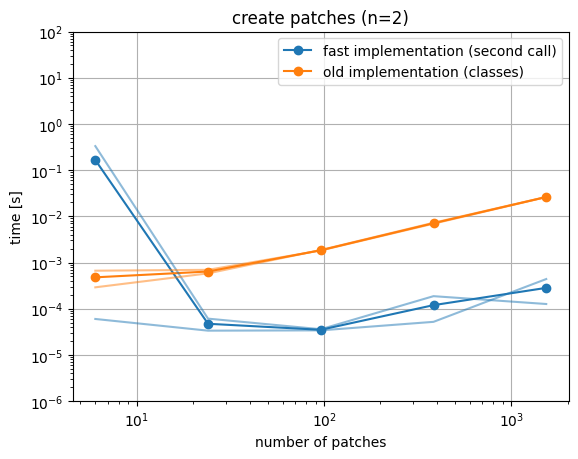

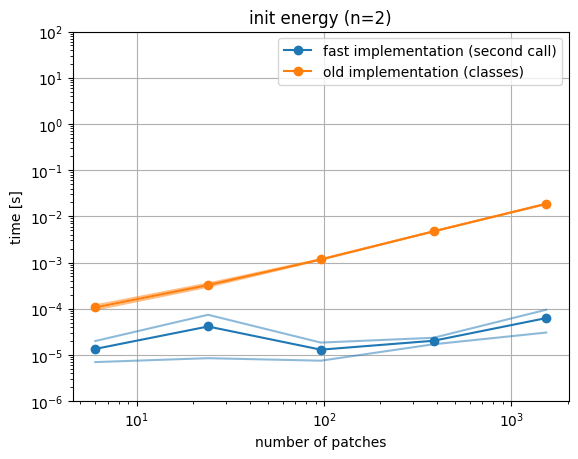

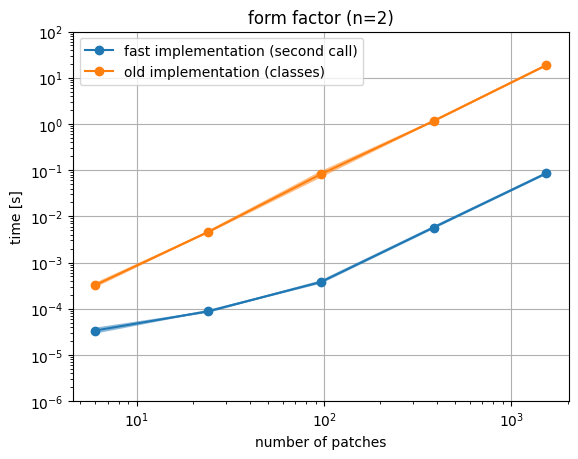

In [5]:
import matplotlib.pyplot as plt

for i in range(steps):
    plt.figure()
    ax = plt.gca()
    # ax.semilogy(number_of_patches, fast_first*1e-6, label='fast implementation (first call)')
    ax.semilogy(
        number_of_patches, np.mean(fast_second[i]*1e-6, axis=-1),
        label='fast implementation (second call)', marker='o')
    ax.semilogy(
        number_of_patches, np.mean(slow[i]*1e-6, axis=-1),
        label='old implementation (classes)', marker='o')
    ax.semilogy(
        number_of_patches, fast_second[i]*1e-6, color='C0', alpha=0.5)
    ax.semilogy(
        number_of_patches, slow[i]*1e-6, color='C1', alpha=0.5)
    ax.grid()
    ax.set_xscale('log')
    ax.set_xlabel('number of patches')
    ax.set_ylabel('time [s]')
    ax.set_title(f'{steps_names[i]} (n={repeat})')
    ax.set_ylim([1e-6, 1e2])
    plt.legend()

In [6]:
n_max = 5
repeat = 2
steps_names = ['create patches', 'visibility']
steps = len(steps_names)
fast_second = np.zeros((steps, n_max, repeat))
slow = np.zeros((steps, n_max, repeat))
number_of_patches = np.zeros((n_max))

# run one time, to get complied.
radiosity = DRadiosityFast.from_polygon(sample_walls, 1)
radiosity.check_visibility()

for i in range(n_max):
    max_size = 1/(2**i)
    start_loop = datetime.now()
    print(f'{datetime.now()} run({i}/{n_max}): {max_size}')
    # run fast two times
    for j in range(repeat):
        # create patches
        start = datetime.now()
        radiosity = DRadiosityFast.from_polygon(sample_walls, max_size)
        delta = (datetime.now() - start)
        fast_second[0, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat

        # form factor
        start = datetime.now()
        radiosity.check_visibility()
        delta = (datetime.now() - start)
        fast_second[1, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat
    number_of_patches[i] = radiosity.n_patches

    delta = (datetime.now() - start_loop)
    delta_seconds = (delta.seconds*1e6 + delta.microseconds)*1e-6
    print(f'{datetime.now()}   took {delta_seconds} seconds')


2024-05-31 16:33:14.827853 run(0/5): 1.0
2024-05-31 16:33:14.842806   took 0.014953 seconds
2024-05-31 16:33:14.842844 run(1/5): 0.5
2024-05-31 16:33:14.843523   took 0.0006789999999999999 seconds
2024-05-31 16:33:14.843545 run(2/5): 0.25
2024-05-31 16:33:14.854236   took 0.010688 seconds
2024-05-31 16:33:14.854291 run(3/5): 0.125
2024-05-31 16:33:14.874230   took 0.019937999999999997 seconds
2024-05-31 16:33:14.874262 run(4/5): 0.0625
2024-05-31 16:33:15.086276   took 0.21201399999999998 seconds


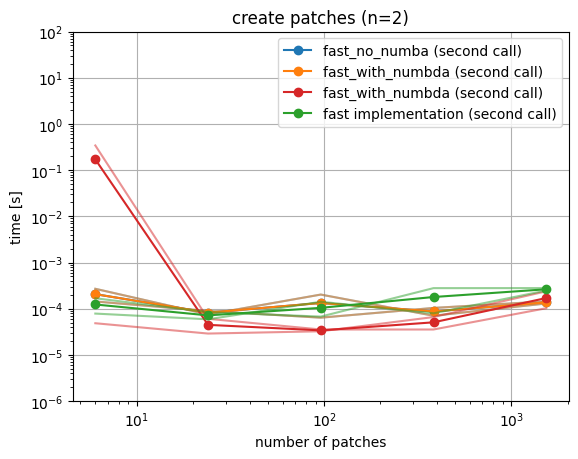

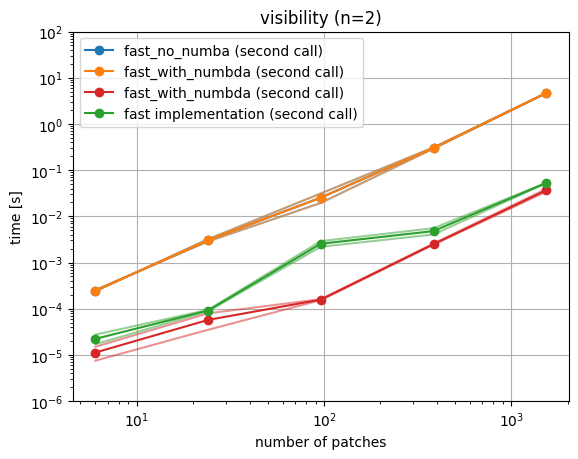

In [7]:
import matplotlib.pyplot as plt
fast_no_numba = np.array([
    [[2.700000e+02, 1.435000e+02],
     [7.500000e+01, 8.950000e+01],
     [2.025000e+02, 6.400000e+01],
     [7.050000e+01, 1.040000e+02],
     [1.300000e+02, 1.440000e+02]],
    [[2.385000e+02, 2.535000e+02],
     [3.204500e+03, 2.862500e+03],
     [3.122400e+04, 1.949800e+04],
     [3.099400e+05, 2.922930e+05],
     [4.641565e+06, 4.652841e+06]]])
fast_with_numbda = np.array([
    [[2.700000e+02, 1.435000e+02],
     [7.500000e+01, 8.950000e+01],
     [2.025000e+02, 6.400000e+01],
     [7.050000e+01, 1.040000e+02],
     [1.300000e+02, 1.440000e+02]],
    [[2.385000e+02, 2.535000e+02],
     [3.204500e+03, 2.862500e+03],
     [3.122400e+04, 1.949800e+04],
     [3.099400e+05, 2.922930e+05],
     [4.641565e+06, 4.652841e+06]]])
fast_numbda_parallel = np.array([
    [[3.41661e+05, 4.85000e+01],
     [6.05000e+01, 2.90000e+01],
     [3.55000e+01, 3.25000e+01],
     [3.55000e+01, 6.60000e+01],
     [1.02500e+02, 2.38000e+02]],
    [[1.50000e+01, 7.50000e+00],
     [7.95000e+01, 3.50000e+01],
     [1.61000e+02, 1.53500e+02],
     [2.56650e+03, 2.43300e+03],
     [3.91465e+04, 3.42075e+04]]])

for i in range(steps):
    plt.figure()
    ax = plt.gca()

    ax.semilogy(
        number_of_patches, np.mean(fast_no_numba[i]*1e-6, axis=-1),
        label='fast_no_numba (second call)', color='C0', marker='o')
    ax.semilogy(
        number_of_patches, fast_no_numba[i]*1e-6, color='C0', alpha=0.5)

    ax.semilogy(
        number_of_patches, np.mean(fast_with_numbda[i]*1e-6, axis=-1),
        label='fast_with_numbda (second call)', color='C1', marker='o')
    ax.semilogy(
        number_of_patches, fast_with_numbda[i]*1e-6, color='C1', alpha=0.5)


    ax.semilogy(
        number_of_patches, np.mean(fast_numbda_parallel[i]*1e-6, axis=-1),
        label='fast_with_numbda (second call)', color='C3', marker='o')
    ax.semilogy(
        number_of_patches, fast_numbda_parallel[i]*1e-6, color='C3', alpha=0.5)

    ax.semilogy(
        number_of_patches, np.mean(fast_second[i]*1e-6, axis=-1),
        label='fast implementation (second call)', color='C2', marker='o')
    ax.semilogy(
        number_of_patches, fast_second[i]*1e-6, color='C2', alpha=0.5)
    # ax.semilogy(
    #     number_of_patches, slow[i]*1e-6, color='C1', alpha=0.5)
    ax.grid()
    ax.set_xscale('log')
    ax.set_xlabel('number of patches')
    ax.set_ylabel('time [s]')
    ax.set_title(f'{steps_names[i]} (n={repeat})')
    ax.set_ylim([1e-6, 1e2])
    plt.legend()

In [8]:
fast_second

array([[[1.6850e+02, 7.8500e+01],
        [8.4500e+01, 5.9000e+01],
        [6.7500e+01, 1.4150e+02],
        [2.7900e+02, 7.9500e+01],
        [2.7950e+02, 2.4750e+02]],

       [[2.7500e+01, 1.7000e+01],
        [9.4500e+01, 8.8500e+01],
        [2.9045e+03, 2.1935e+03],
        [5.5305e+03, 4.0455e+03],
        [5.3090e+04, 5.2371e+04]]])

In [9]:
slow

array([[[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]]])

In [10]:
cProfile.run('radiosity.check_visibility()')

         8 function calls in 0.088 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.088    0.088 <string>:1(<module>)
        1    0.000    0.000    0.088    0.088 radiosity_fast.py:109(check_visibility)
        1    0.000    0.000    0.000    0.000 radiosity_fast.py:165(patches_center)
        1    0.000    0.000    0.000    0.000 radiosity_fast.py:180(patches_normal)
        1    0.088    0.088    0.088    0.088 radiosity_fast.py:366(check_visibility)
        1    0.000    0.000    0.000    0.000 serialize.py:30(_numba_unpickle)
        1    0.000    0.000    0.088    0.088 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}


